In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas
import folium
from haversine import haversine

In [2]:
LOGS = ["matsumoto-nagano-100318.log", "nagano-matsumoto-100318.log"]

In [3]:
''' 課題10の2
GPS受信器から出力されるデータから日付・時間を抽出して表示します。

利用方法：
LOGSにNMEAフォーマットのGPRMCデータを含むログファイルを指定。
python3 q02.py

注意点：
ここではGPRMCのデータだけを抽出します。
入力データはUTCと思われます。JSTにして表示します。
'''
for logfile in LOGS:
    print(logfile+":GPRMC")
    with open(logfile) as f:
        for line in f:
            if "$GPRMC" in line:
                gprmc = line.split(',')
                datetime_utc = datetime.datetime.strptime(
                    gprmc[9] + gprmc[1], '%d%m%y%H%M%S')
                datetime_jst = datetime_utc + datetime.timedelta(hours=9)
                print(datetime_jst)

matsumoto-nagano-100318.log:GPRMC
2010-03-18 15:19:59
2010-03-18 15:20:09
2010-03-18 15:20:28
2010-03-18 15:20:43
2010-03-18 15:20:58
2010-03-18 15:21:13
2010-03-18 15:21:25
2010-03-18 15:21:36
2010-03-18 15:21:51
2010-03-18 15:22:06
2010-03-18 15:22:21
2010-03-18 15:22:36
2010-03-18 15:22:51
2010-03-18 15:23:06
2010-03-18 15:23:28
2010-03-18 15:23:37
2010-03-18 15:23:52
2010-03-18 15:24:07
2010-03-18 15:24:22
2010-03-18 15:24:37
2010-03-18 15:24:52
2010-03-18 15:25:07
2010-03-18 15:25:22
2010-03-18 15:25:37
2010-03-18 15:25:58
2010-03-18 15:26:09
2010-03-18 15:26:20
2010-03-18 15:26:42
2010-03-18 15:26:50
2010-03-18 15:27:12
2010-03-18 15:27:27
2010-03-18 15:27:42
2010-03-18 15:27:57
2010-03-18 15:28:06
2010-03-18 15:28:27
2010-03-18 15:28:42
2010-03-18 15:28:57
2010-03-18 15:29:12
2010-03-18 15:29:27
2010-03-18 15:29:42
2010-03-18 15:29:51
2010-03-18 15:30:06
2010-03-18 15:30:27
2010-03-18 15:30:42
2010-03-18 15:30:51
2010-03-18 15:31:06
2010-03-18 15:31:21
2010-03-18 15:31:36
2010-0

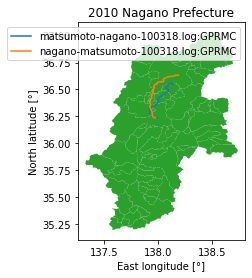

In [4]:
''' 課題10の3
GPS受信器から出力されるデータから緯度・経度を抽出して、「横軸：経度、縦軸：緯度」のプロットを作ります。
また、背面にShapeファイルで指定した地図を表示します。

利用方法：
LOGSにNMEAフォーマットのGPRMCデータを含むログファイルを指定。
SHAPEにログの位置情報全体を含むShapeファイルを指定。
python3 q03.py

注意点：
ここではGPRMCのデータだけを抽出します。
北緯と南緯をまたいだり、東経と西経をまたいだりする移動のプロットはサポートしていません。
各都道府県・全国のShapeファイルは国土交通省が公開しています。
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v3_0.html#prefecture20
デフォルトではログファイルと同じ2010年の長野県全体のデータを指定しています。
事前にpython3 -m pip install matplotlib geopandasを行う必要があります。
geopandasについては依存関係のパッケージが多いので環境を壊さないように、まずはvenvで試してみることをお勧めします。
'''
SHAPE = "N03-101001_20_GML/N03-10_20_101001.shp"

nagano = geopandas.read_file(SHAPE)
nagano.plot(color="tab:green")
longitudes = {}
latitudes = {}

f = folium.Figure()
center_lat, center_lon = 36.5, 138.1
m = folium.Map([center_lat, center_lon], zoom_start=10).add_to(f)
COLORS = ["blue", "orange"]

for i, logfile in enumerate(LOGS):
    longitudes[logfile] = []
    latitudes[logfile] = []
    with open(logfile) as f:
        for line in f:
            if "$GPRMC" in line:
                gprmc = line.split(',')
                # 経度
                west_or_east = gprmc[6]
                longitude_dddmm_mmmm = float(gprmc[5])
                longitude_ddd = int(longitude_dddmm_mmmm/100)
                longitude = longitude_ddd + \
                    (longitude_dddmm_mmmm-longitude_ddd*100)/60
                longitudes[logfile].append(longitude)
                # 緯度
                north_or_sourth = gprmc[4]
                latitude_dddmm_mmmm = float(gprmc[3])
                latitude_ddd = int(latitude_dddmm_mmmm/100)
                latitude = latitude_ddd + \
                    (latitude_dddmm_mmmm-latitude_ddd*100)/60
                latitudes[logfile].append(latitude)
#                 folium.Marker(location=[latitude, longitude]).add_to(m)

                datetime_utc = datetime.datetime.strptime(
                    gprmc[9] + gprmc[1], '%d%m%y%H%M%S')
                datetime_jst = datetime_utc + datetime.timedelta(hours=9)
                m.add_child(
                    folium.Marker(
                        location=[latitude, longitude],
                        popup=datetime_jst.__str__(),
                        icon=folium.Icon(color=COLORS[i])
                    )
                )
    plt.plot(longitudes[logfile], latitudes[logfile],
             label=logfile+":GPRMC")
plt.title("2010 Nagano Prefecture")
plt.legend()
if west_or_east == 'W':
    plt.xlabel("West longitude [°]")
elif west_or_east == 'E':
    plt.xlabel("East longitude [°]")
if north_or_sourth == 'N':
    plt.ylabel("North latitude [°]")
elif north_or_sourth == 'S':
    plt.ylabel("South latitude [°]")
plt.show()

m

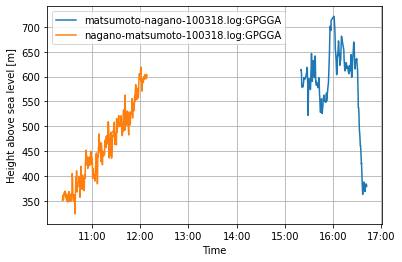

In [5]:
''' 課題10の4
GPS受信器から出力されるデータから高度を抽出して、「横軸：時間、縦軸：高度」のプロットを作ります。

利用方法：
LOGSにNMEAフォーマットのGPGGAデータを含むログファイルを指定。
python3 q04.py

注意点：
ここではGPGGAのデータだけを抽出します。
日付をまたぐ場合のプロットをサポートしていません。
事前にpython3 -m pip install matplotlibを行う必要があります。
'''

fig = plt.figure()
ax = fig.add_subplot(111)
datetimes_jst = {}
heights_above_sealevel = {}
for logfile in LOGS:
    datetimes_jst[logfile] = []
    heights_above_sealevel[logfile] = []
    with open(logfile) as f:
        for line in f:
            if "$GPGGA" in line:
                gpgga = line.split(',')
                time_utc = gpgga[1]
                datetime_utc = datetime.datetime.strptime(
                    time_utc, '%H%M%S')
                datetime_jst = datetime_utc + datetime.timedelta(hours=9)
                height_above_sealevel = float(gpgga[9])
                datetimes_jst[logfile].append(datetime_jst)
                heights_above_sealevel[logfile].append(height_above_sealevel)
    ax.plot(datetimes_jst[logfile],
            heights_above_sealevel[logfile], label=logfile+":GPGGA")
plt.grid()
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Time")
plt.ylabel("Height above sea level [" + gpgga[10].lower()+"]")
plt.show()


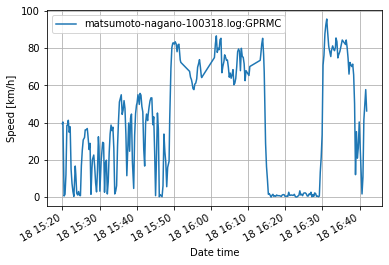

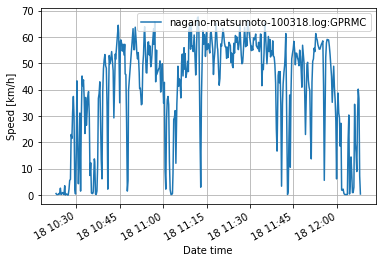

In [6]:
''' 課題10の5
GPS受信器から出力されるデータから速度を抽出します。
 [km/h] に変換して「横軸：時間、縦軸：速度」のプロットを作ります

利用方法：
LOGSにNMEAフォーマットのGPRMCデータを含むログファイルを指定。
python3 q05.py

注意点：
ここではGPRMCのデータだけを抽出します。
入力データはUTCと思われます。JSTにしてプロットします。
事前にpython3 -m pip install matplotlibを行う必要があります。
'''

datetimes_jst = {}
speeds = {}
for logfile in LOGS:
    datetimes_jst[logfile] = []
    speeds[logfile] = []
    plt.figure()
    with open(logfile) as f:
        for line in f:
            if "$GPRMC" in line:
                gprmc = line.split(',')
                datetime_utc = datetime.datetime.strptime(
                    gprmc[9] + gprmc[1], '%d%m%y%H%M%S')
                datetime_jst = datetime_utc + datetime.timedelta(hours=9)
                speed = float(gprmc[7])*1.852
                datetimes_jst[logfile].append(datetime_jst)
                speeds[logfile].append(speed)
    plt.plot(datetimes_jst[logfile], speeds[logfile], label=logfile+":GPRMC")
    plt.grid()
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date time")
    plt.ylabel("Speed [km/h]")
plt.show()

In [7]:
''' 課題10の6
GPS受信器から出力されるデータから移動距離を計算します。

利用方法：
LOGSにNMEAフォーマットのGPRMCデータを含むログファイルを指定。
python3 q06.py

注意点：
事前にpython3 -m pip install haversineを行う必要があります。
'''
LOGS = ["matsumoto-nagano-100318.log", "nagano-matsumoto-100318.log"]

for logfile in LOGS:
    first_loop = True
    sum_distance = 0
    with open(logfile) as f:
        for line in f:
            if "$GPRMC" in line:
                gprmc = line.split(',')
                # 経度
                west_or_east = gprmc[6]
                longitude_dddmm_mmmm = float(gprmc[5])
                longitude_ddd = int(longitude_dddmm_mmmm/100)
                longitude = longitude_ddd + \
                    (longitude_dddmm_mmmm-longitude_ddd*100)/60
                # 緯度
                north_or_sourth = gprmc[4]
                latitude_dddmm_mmmm = float(gprmc[3])
                latitude_ddd = int(latitude_dddmm_mmmm/100)
                latitude = latitude_ddd + \
                    (latitude_dddmm_mmmm-latitude_ddd*100)/60
                if first_loop:
                    first_loop = False
                else:
                    distance = haversine(
                        (old_longitude, old_latitude), (longitude, latitude))
                    sum_distance += distance
                old_longitude = longitude
                old_latitude = latitude
    print(logfile+":GPRMC"'\t'+str(sum_distance)+" [km]")

matsumoto-nagano-100318.log:GPRMC	55.22843573386763 [km]
nagano-matsumoto-100318.log:GPRMC	68.95918844316489 [km]
